# RAF-DB - all classes
**Author**: Johannes S. Fischer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

from dataloader import load_RAF_targetvector
from model import get_base_model

In [2]:
model_name = 'RAF'

Load pretrained model to fine-tune it? If yes, specify model name, if no set it to ```None```.

In [3]:
pretrained_model_name = None

# Data

## Preprocessing Function
Preprocessing function, where pixel values per channel are normalized to have zero mean and unit variance. Mean and standard-deviation are obtained from the training set only.

In [4]:
# RAF-DB training data mean and std
mean = [146.6770, 114.6274, 102.3102]
std = [67.6282, 61.7651, 61.3665]

def preprocess(x):
    # ensure image format
    x = np.array(x, dtype='float32')
    
    # normalize
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    if std is not None:
        x[..., 0] /= std[0]
        x[..., 1] /= std[1]
        x[..., 2] /= std[2] 
    return x

def de_preprocess(x):
    if std is not None:
        x[..., 0] *= std[0]
        x[..., 1] *= std[1]
        x[..., 2] *= std[2]
    # normalize
    x[..., 0] += mean[0]
    x[..., 1] += mean[1]
    x[..., 2] += mean[2]
    return x.astype('uint8')

## Load Data

In [5]:
%%time

# settings
DATA_DIR = './data/RAF/'

IMG_SIZE = (100, 100)
IMG_SHAPE = IMG_SIZE + (3,)

BATCH_SIZE = 64

# load data
train_ds, val_ds, test_ds = load_RAF_targetvector(DATA_DIR,
                                                  target_img_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  preprocessing_function=preprocess)

Splitting test dataset into stratified validation and test set
Training
- (12271, 100, 100, 3) 
- (12271, 7)
Validation
- (1534, 100, 100, 3) 
- (1534, 7)
Testing
- (1534, 100, 100, 3) 
- (1534, 7)
Wall time: 15.1 s


Prepare some function to get labels...

In [6]:
emotion_labels = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']

num_classes = len(emotion_labels)
print("Number of classes: ", num_classes)

def vec2label(onehot_vec):
    major_vote = np.argmax(onehot_vec)
    return emotion_labels[major_vote]

Number of classes:  7


## Data Examples

Show some examples...

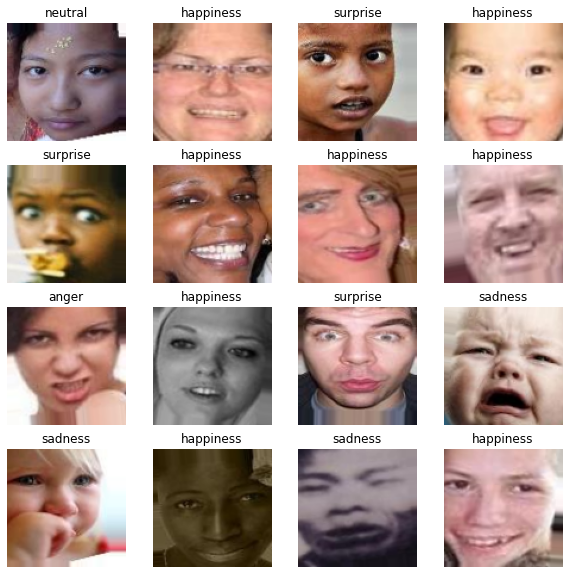

In [7]:
images, labels = next(train_ds)

plt.subplots(4,4, figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(
        de_preprocess(images[i])
    )
    plt.title(vec2label(labels[i]))
    plt.axis('off')
plt.show()

# Model

## Base model
Architecture of the model without classification layer.

In [8]:
model = get_base_model(IMG_SHAPE)

## Classification model
Add classification layer to the base model.

In [9]:
model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="softmax"))

# load pretrained version if required
if pretrained_model_name is not None:
    model.load_weights(f'./models/{pretrained_model_name}')

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (ConvLayer)     (None, 100, 100, 64)      2048      
_________________________________________________________________
block1_conv2 (ConvLayer)     (None, 100, 100, 64)      37184     
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 33, 33, 64)        0         
_________________________________________________________________
block2_conv1 (ConvLayer)     (None, 33, 33, 96)        55776     
_________________________________________________________________
block2_conv2 (ConvLayer)     (None, 33, 33, 96)        83424     
_________________________________________________________________
block2_conv3 (ConvLayer)     (None, 33, 33, 96)        83424     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 11, 11, 96)        0

# Training

In [10]:
# callbacks
dt = datetime.now().strftime("%m%d-%H%M")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f"./modelcheckpoints/{model_name}_{dt}",
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=4,
                                         verbose=1,
                                         mode='auto',
                                         min_lr=0.00000001),
    tf.keras.callbacks.CSVLogger(f'./log/{model_name}_{dt}.csv',
                                 separator=",", append=True)
]

In [11]:
%%time

epochs = 20

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/20
192/192 [==============================] - 52s 230ms/step - loss: 1.5901 - accuracy: 0.4057 - val_loss: 1.6191 - val_accuracy: 0.3918

Epoch 00001: val_accuracy improved from -inf to 0.39179, saving model to ./modelcheckpoints\RAF_0325-1330


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


Epoch 2/20
192/192 [==============================] - 43s 221ms/step - loss: 1.3272 - accuracy: 0.5492 - val_loss: 1.4029 - val_accuracy: 0.5117

Epoch 00002: val_accuracy improved from 0.39179 to 0.51173, saving model to ./modelcheckpoints\RAF_0325-1330


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


Epoch 3/20
192/192 [==============================] - 42s 220ms/step - loss: 1.1687 - accuracy: 0.6355 - val_loss: 2.2430 - val_accuracy: 0.2881

Epoch 00003: val_accuracy did not improve from 0.51173
Epoch 4/20
192/192 [==============================] - 42s 220ms/step - loss: 1.0913 - accuracy: 0.6824 - val_loss: 1.3604 - val_accuracy: 0.5743

Epoch 00004: val_accuracy improved from 0.51173 to 0.57432, saving model to ./modelcheckpoints\RAF_0325-1330


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


Epoch 5/20
192/192 [==============================] - 43s 222ms/step - loss: 1.0482 - accuracy: 0.7123 - val_loss: 1.9272 - val_accuracy: 0.4081

Epoch 00005: val_accuracy did not improve from 0.57432
Epoch 6/20
192/192 [==============================] - 42s 220ms/step - loss: 1.0234 - accuracy: 0.7277 - val_loss: 1.2608 - val_accuracy: 0.6330

Epoch 00006: val_accuracy improved from 0.57432 to 0.63299, saving model to ./modelcheckpoints\RAF_0325-1330


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


Epoch 7/20
192/192 [==============================] - 42s 220ms/step - loss: 0.9988 - accuracy: 0.7468 - val_loss: 1.0939 - val_accuracy: 0.7223

Epoch 00007: val_accuracy improved from 0.63299 to 0.72229, saving model to ./modelcheckpoints\RAF_0325-1330


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


Epoch 8/20
192/192 [==============================] - 42s 219ms/step - loss: 0.9794 - accuracy: 0.7592 - val_loss: 1.1473 - val_accuracy: 0.6682

Epoch 00008: val_accuracy did not improve from 0.72229
Epoch 9/20
192/192 [==============================] - 42s 220ms/step - loss: 0.9679 - accuracy: 0.7671 - val_loss: 1.0325 - val_accuracy: 0.7568

Epoch 00009: val_accuracy improved from 0.72229 to 0.75684, saving model to ./modelcheckpoints\RAF_0325-1330


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


Epoch 10/20
192/192 [==============================] - 42s 220ms/step - loss: 0.9504 - accuracy: 0.7763 - val_loss: 0.9787 - val_accuracy: 0.7653

Epoch 00010: val_accuracy improved from 0.75684 to 0.76532, saving model to ./modelcheckpoints\RAF_0325-1330


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


Epoch 11/20
192/192 [==============================] - 42s 220ms/step - loss: 0.9379 - accuracy: 0.7864 - val_loss: 1.6237 - val_accuracy: 0.5378

Epoch 00011: val_accuracy did not improve from 0.76532
Epoch 12/20
192/192 [==============================] - 42s 220ms/step - loss: 0.9285 - accuracy: 0.7928 - val_loss: 0.9780 - val_accuracy: 0.7907

Epoch 00012: val_accuracy improved from 0.76532 to 0.79074, saving model to ./modelcheckpoints\RAF_0325-1330


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


Epoch 13/20
192/192 [==============================] - 42s 220ms/step - loss: 0.9185 - accuracy: 0.8021 - val_loss: 1.0132 - val_accuracy: 0.7777

Epoch 00013: val_accuracy did not improve from 0.79074
Epoch 14/20
192/192 [==============================] - 42s 220ms/step - loss: 0.9118 - accuracy: 0.8087 - val_loss: 0.9953 - val_accuracy: 0.7451

Epoch 00014: val_accuracy did not improve from 0.79074
Epoch 15/20
192/192 [==============================] - 42s 220ms/step - loss: 0.9017 - accuracy: 0.8114 - val_loss: 1.0886 - val_accuracy: 0.7549

Epoch 00015: val_accuracy did not improve from 0.79074
Epoch 16/20
192/192 [==============================] - 42s 220ms/step - loss: 0.8937 - accuracy: 0.8185 - val_loss: 1.0788 - val_accuracy: 0.7555

Epoch 00016: val_accuracy did not improve from 0.79074

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 17/20
192/192 [==============================] - 42s 220ms/step - loss: 0.8593 - accuracy: 0.8444 - val_

INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


Epoch 18/20
192/192 [==============================] - 43s 220ms/step - loss: 0.8477 - accuracy: 0.8514 - val_loss: 0.8909 - val_accuracy: 0.8403

Epoch 00018: val_accuracy improved from 0.81095 to 0.84029, saving model to ./modelcheckpoints\RAF_0325-1330


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\RAF_0325-1330\assets


Epoch 19/20
192/192 [==============================] - 42s 220ms/step - loss: 0.8436 - accuracy: 0.8550 - val_loss: 0.8909 - val_accuracy: 0.8396

Epoch 00019: val_accuracy did not improve from 0.84029
Epoch 20/20
192/192 [==============================] - 43s 222ms/step - loss: 0.8388 - accuracy: 0.8608 - val_loss: 0.9075 - val_accuracy: 0.8266

Epoch 00020: val_accuracy did not improve from 0.84029
Wall time: 14min 56s


# Results

## Training Results

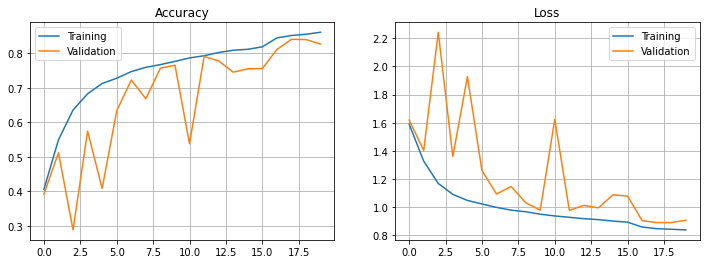

In [12]:
plt.figure(figsize=(12, 4))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.grid(); plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.grid(); plt.legend()
plt.show()

## Test Results

In [13]:
loss, acc = model.evaluate(test_ds, verbose=2)

print("\nAccuracy:\t%.2f%%" % (acc * 100))
print("Loss:\t\t%.4f" % (loss))

24/24 - 2s - loss: 0.9144 - accuracy: 0.8031

Accuracy:	80.31%
Loss:		0.9144


# Save Model

In [14]:
save_model = True

if save_model:
    model.save_weights('./models/' + model_name + "_" + dt + '_weights.h5')
    
    # log info about model
    f = open("./models/info.txt", "a")
    txt = model_name + "_" + dt + ":"
    txt += " val=" + str(np.max(history.history['val_accuracy'])*100) + ";"
    txt += " test=" + str(acc*100) + "\n"
    f.write(txt)
    f.close()

---